# Kalman Filter

The Kalman Filter is a sophisticated mathematical tool used to estimate the "true state" of a system from noisy measurements. In finance, it is often used as a "smart" moving average that adapts to market volatility better than traditional methods.

In time‑series analysis (e.g., stock prices) the objective is to remove noise while preserving the underlying signal. Below is a concise comparison of three common smoothing/estimation methods.

| Indicator | Logic | Lag | Adaptability |
|---|---|---:|---|
| **SMA** (Simple Moving Average) | Arithmetic mean of the last $N$ periods | High | Static — all points weighted equally |
| **EMA** (Exponential Moving Average) | Exponentially weighted average (recent data has more weight) | Medium | Semi‑adaptive — better than SMA but relies on a fixed decay factor |
| **Kalman Filter** | Recursive state‑space estimator that balances model prediction with measurements | Low | Dynamic — gain updates automatically based on process/measurement noise and error |

Key notes
- SMA: Simple and robust; good as a baseline or for low‑volatility regimes. Suffers from significant lag and slow responsiveness to regime changes.
- EMA: Faster reaction to recent changes with a single tunable decay parameter (alpha). Easy to compute and widely used in trading signals.
- Kalman Filter: Treats the true value as a latent state and fuses predictions and noisy observations, adjusting its trust (gain) over time. It can track signals with minimal lag and adapt to changing volatility, but requires specifying (or estimating) process noise (Q) and measurement noise (R) and possibly a transition model.

When to use what
- Use **SMA** for simple smoothing or benchmarking.
- Use **EMA** when you need a lighter, low‑cost smoother that reacts faster than SMA.
- Use **Kalman Filter** when adaptivity and minimal lag matter and you can reasonably model noise characteristics.

Practical tip: try EMA or SMA for quick prototypes; move to a Kalman Filter when you need adaptive, low‑lag estimates and are ready to tune Q/R (or learn them from data).

In [1]:
!pip install pykalman

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/249.4 kB ? eta -:--:--
     ----                                  30.7/249.4 kB 660.6 kB/s eta 0:00:01
     ----------                            71.7/249.4 kB 787.7 kB/s eta 0:00:01
     --------------------                 143.4/249.4 kB 950.9 kB/s eta 0:00:01
     -----------------------------------    235.5/249.4 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 249.4/249.4 kB 1.3 MB/s eta 0:00:00
                                              0.0/151.5 kB ? eta -:--:--
     -------------------------------------- 151.5/151.5 kB 4.4 MB/s eta 0:00:00


### 1. Import Libraries

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 7]

### 2. Synthetic Data Generation
We simulate a stock price with an underlying trend plus random market noise.

In [ ]:
ticker = "NVDA" 
start_date = "2024-01-01"
end_date = "2025-12-28"

raw_data = yf.download(ticker, start=start_date, end=end_date)

# We use 'Close' price for the calculation
# Use .dropna() to ensure no missing values
df = pd.DataFrame(raw_data['Close']).dropna()
df.columns = ['Price']

print(df)
print("Successfully downloaded data")

[*********************100%***********************]  1 of 1 completed

                 Price
Date                  
2024-01-02   48.141178
2024-01-03   47.542515
2024-01-04   47.971279
2024-01-05   49.069664
2024-01-08   52.223907
...                ...
2025-12-19  180.990005
2025-12-22  183.690002
2025-12-23  189.210007
2025-12-24  188.610001
2025-12-26  190.529999

[499 rows x 1 columns]
Successfully downloaded data


### 3. Calculate SMA and EMA

In [18]:
window = 20

# Simple Moving Average
df['SMA'] = df['Price'].rolling(window=window).mean()

# Exponential Moving Average
# ให้ความสำคัญกับราคาล่าสุดมากกว่า
df['EMA'] = df['Price'].ewm(span=window, adjust=False).mean()

print("Successfully calculated SMA and EMA")

Successfully calculated SMA and EMA


### 4. Apply Kalman Filter to Real Data

Think of it as a "Smart Moving Average" that decides every day how much it should trust the new market price versus its own previous prediction.

In [ ]:
def kalman_filter(data, Q=1e-4, R=0.01**2):
    # Q is Process Variance: How much you expect the "true" price to move. (High Q = fast trend).
    # R is Measurement Variance: How noisy you expect the measurements to be. (High R = noisy data).
    n = len(data)
    x_hat = np.zeros(n)   # Estimated state: The Filtered Price (the output we want).
    P = np.zeros(n)       # Estimation Error Covariance: Uncertainty in the estimate.
    
    # Initialization
    x_hat[0] = data[0]
    P[0] = 1.0

    for k in range(1, n):
        # Predict
        x_hat_minus = x_hat[k-1]  # Guess that today's price is the same as yesterday's.
        P_minus = P[k-1] + Q      # Uncertainty grows because time has passed (+Q).

        # Update
        K = P_minus / (P_minus + R)     # Kalman Gain: How much we trust the measurement vs our prediction.   if K is high => trust measurement more

        x_hat[k] = x_hat_minus + K * (data[k] - x_hat_minus)
        P[k] = (1 - K) * P_minus
        
    return x_hat

# Apply the filter (Adjust Q/R based on stock volatility)
df['Kalman'] = kalman_filter(df['Price'].values, Q=0.05, R=1.5**2)
# Q=0.05: This allows the filter to be somewhat flexible. If you make this $0.0001$, the line will become extremely flat and laggy.
# R=1.5**2: We are telling the filter that the "standard deviation" of the noise is about $\$1.5$. If the price jumps by $\$1.0$, the filter will treat it mostly as noise and won't react violently.
print("Kalman Filter optimization complete.")

Kalman Filter optimization complete.


### 5. Visual Comparison

compare SMA, EMA and Kalman-Filter

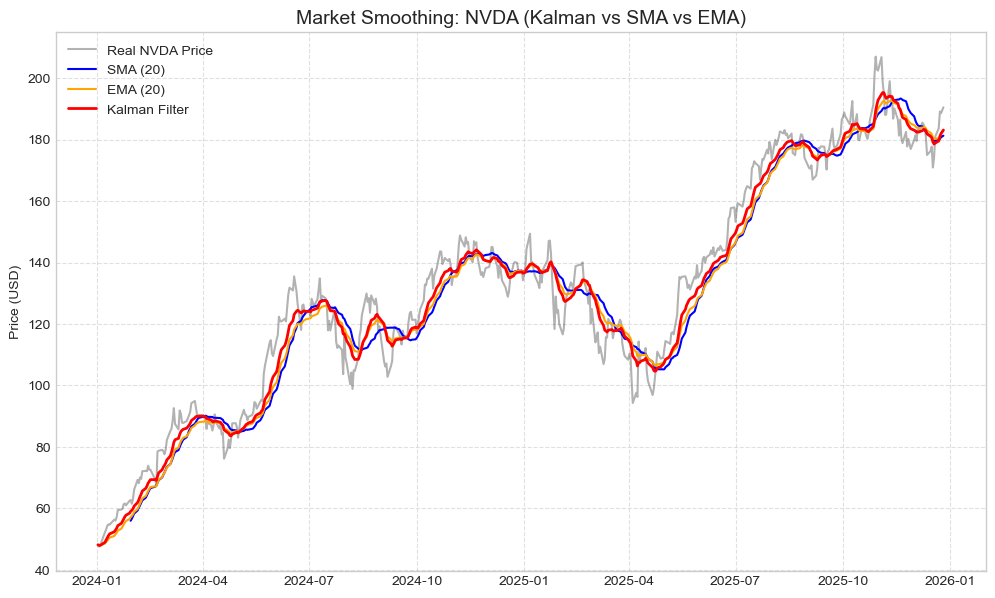

In [20]:
plt.plot(df['Price'], label=f'Real {ticker} Price', color='black', alpha=0.3)
plt.plot(df['SMA'], label='SMA (20)', color='blue', linewidth=1.5)
plt.plot(df['EMA'], label='EMA (20)', color='orange', linewidth=1.5)
plt.plot(df['Kalman'], label='Kalman Filter', color='red', linewidth=2)

plt.title(f'Market Smoothing: {ticker} (Kalman vs SMA vs EMA)', fontsize=14)
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Another Usecase of Kalman Filter

- Estimate Beta
- Calculate Spread
- MEan Reversion